# Statistical Testing Templates for CPTAC Data

<b>Standard imports for playing with and plotting data frames.</b>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.stats.multitest
#import altair as alt
#alt.renderers.enable('notebook') #Necessary for Altair to work

In [2]:
import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [30]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

#Try Looking at all proteins, not just interacting proteins
all_proteins = list(proteomics.columns.values)
print(len(all_proteins))
print(all_proteins)

10999
['A1BG', 'A2M', 'A2ML1', 'A4GALT', 'AAAS', 'AACS', 'AADAT', 'AAED1', 'AAGAB', 'AAK1', 'AAMDC', 'AAMP', 'AAR2', 'AARS', 'AARS2', 'AARSD1', 'AASDHPPT', 'AASS', 'AATF', 'ABAT', 'ABCA8', 'ABCB1', 'ABCB10', 'ABCB6', 'ABCB7', 'ABCB8', 'ABCC1', 'ABCC10', 'ABCC3', 'ABCC4', 'ABCD1', 'ABCD3', 'ABCD4', 'ABCE1', 'ABCF1', 'ABCF2', 'ABCF3', 'ABCG1', 'ABHD10', 'ABHD11', 'ABHD12', 'ABHD13', 'ABHD14A', 'ABHD14A-ACY1', 'ABHD14B', 'ABHD16A', 'ABHD17A', 'ABHD17B', 'ABHD17C', 'ABHD2', 'ABHD3', 'ABHD4', 'ABHD5', 'ABHD6', 'ABI1', 'ABI2', 'ABI3', 'ABI3BP', 'ABL1', 'ABL2', 'ABLIM1', 'ABLIM2', 'ABLIM3', 'ABO', 'ABR', 'ABRACL', 'ABRAXAS1', 'ABRAXAS2', 'ABT1', 'ABTB2', 'ACAA1', 'ACAA2', 'ACACA', 'ACACB', 'ACAD10', 'ACAD11', 'ACAD8', 'ACAD9', 'ACADL', 'ACADM', 'ACADS', 'ACADSB', 'ACADVL', 'ACAP1', 'ACAP2', 'ACAP3', 'ACAT1', 'ACAT2', 'ACBD3', 'ACBD5', 'ACBD6', 'ACBD7', 'ACD', 'ACE', 'ACIN1', 'ACLY', 'ACO1', 'ACO2', 'ACOT1', 'ACOT11', 'ACOT13', 'ACOT2', 'ACOT4', 'ACOT7', 'ACOT8', 'ACOT9', 'ACOX1', 'ACOX2', 'AC

## t-test for effects of all mutations combined
<b>Note:</b> You can put any number of proteins in the list and it will compare that gene with the protein levels of all of them

### List of interacting proteins (according to STRING and Uniprot)

In [23]:
#Build the protein list; this may have only a single protein if desired
protList = ['IRS1', 'IRS2', 'RRAS', 'AKT2', 'NRAS', 'PTEN', 'AKT1', 'MRAS', 'HRAS', 'RPS6KB1', 'PIK3R1', 'PKC', 'MTOR', 'S6K', 'MAPK', 'ERBB3', 'P85A', 'P55G', 'CDK5']
protList = all_proteins

In [24]:
gene = 'PIK3CA'
tested = [];
p_vals = [];
for protein in protList: 
    if protein in proteomics.columns:
        tested.append(protein)
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross[:100]
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] != "Wildtype"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        p_vals.append(ttest[1])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_vals)[0]
pvals = statsmodels.stats.multitest.fdrcorrection(p_vals)[1]
significant_proteins = np.array(tested)[np.array(areSignificant)]
significant_pvals = np.array(pvals)[np.array(areSignificant)]

/anaconda3/lib/python3.6/site-packages/statsmodels/stats/multitest.py:320: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


In [26]:
print(significant_proteins)
print(significant_pvals)

[]
[]


### Test for phosphorylation levels (mutation in any gene with phosphorylation of any protein)

In [44]:
#List of proteins (will test all phosphorylation sites on these proteins)
phosProtList = protList

In [ ]:
sites = phos.columns
p_values = []
site_names = []

for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
        for site in phosphositesdf.columns:
            if (site is not 'Mutation'):
                sitedf = CPTAC.compare_mutations(phos, site, gene)
                mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
                wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
                ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
                p_values.append(ttest[1])
                site_names.append(site)     



#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])
#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'
        

pvalues = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[1]         
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[0]

significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)

### Plot phosphorylation levels and gene mutation
<b>Note:</b> There may be fewer data points due to NA values

INDEX MIN:  327  PVAL:  1.3722220803561899e-05
SIGNIFICANT SITES LENGTH:  338
      ANKIB1-S737           Mutation Patient_Type
S001      0.06750  Missense_Mutation        Tumor
S002      0.27300           Wildtype        Tumor
S003      0.21520  Missense_Mutation        Tumor
S004     -0.23465           Wildtype        Tumor
S005      0.56200           Wildtype        Tumor
S006     -0.10700           Wildtype        Tumor
S007      1.20000           Wildtype        Tumor
S008      0.01580           Wildtype        Tumor
S009     -0.28750  Missense_Mutation        Tumor
S010      0.18300  Missense_Mutation        Tumor
S011      0.15010           Wildtype        Tumor
S012      0.50050  Missense_Mutation        Tumor
S013     -0.13545           Wildtype        Tumor
S014      0.41100  Missense_Mutation        Tumor
S015     -0.14800           Wildtype        Tumor
S016      0.11600           Wildtype        Tumor
S017      0.71700           Wildtype        Tumor
S018      0.13350  Mis

[Text(0, 0.5, 'Phosphoproteomics'), Text(0.5, 0, 'Somatic Gene Mutation')]

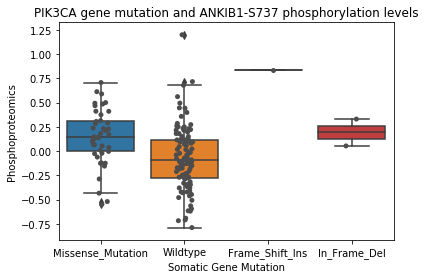

In [42]:
#Specify the gene and the site; you may use a string to specify the site or reference the significant results above

index_min = significant_pvalues.tolist().index(min(significant_pvalues))
print("INDEX MIN: ", index_min, " PVAL: ", significant_pvalues[index_min])
gene = 'PIK3CA'
site = significant_sites[index_min]
print("SIGNIFICANT SITES LENGTH: ", len(significant_sites))

#print(somatic_mutations)

#Build the dataframe for plotting
#genedf = somatic_mutations[gene].to_frame()
genedf = CPTAC.compare_mutations(phos, site, gene)

print(genedf)
#sites = phos.filter(regex=site)
#genedf = genedf.add(sites, fill_value=0)

phos_boxplot = sns.boxplot(data=genedf, x="Mutation" ,y=site)
phos_boxplot.set_title(gene + " gene mutation and " + site + " phosphorylation levels")
phos_boxplot = sns.stripplot(data=genedf, x="Mutation", y=site,jitter=True, color=".3")
phos_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")

### Test for phosphorylation levels and protein abundance

In [43]:
#Specify the pattern for all phosphorylation sites as well as the protein of interest
phosProt = phos.filter(regex='PIK3CA') 
protein = 'PIK3CA'
sigPhosProtResults = []

#Build dataframe with protein levels and phosphorylation levels
proteindf = proteomics[protein].to_frame()
phosProtCross = proteindf.add(phosProt, fill_value=0)

#Bonferroni correction
pcutoff = 0.05/len(cross.columns)

#Test each site for significance and print the results
for loc in phosProtCross.columns:
    if not loc == protein:
        oneSitedf = phosProtCross[[loc, protein]].dropna(axis=0)
        pearsonresult = pearsonr(oneSitedf[loc], oneSitedf[protein])
        if(pearsonresult[1] < pcutoff):
            sigPhosProtResults.append(loc)
            print("Results for " + loc)
            print(pearsonresult)

Results for PIK3CA-S312
(0.5597690804706072, 9.70607537359938e-09)
Results for PIK3CA-T313
(0.5795790014886743, 2.1587859293485523e-09)


### Scatterplot of phosphorylation levels vs. protein abundance (mutation included)

In [39]:
#Specify a protein, a gene and a site; you may use a string to specify the site or reference sigPhosProtResults above
protein = 'CTNNB1'
gene = 'CTNNB1'
site = sigPhosProtResults[1]

#Build the dataframe for plotting
protdf = proteomics[protein].to_frame()
protdfName = protein + " protein levels" #Technically only necessary when the gene and the protein have the same name
protdf.columns = [protdfName]
sites = phos.filter(regex=site)
protdf = protdf.add(sites, fill_value=0)

genedf = somatic_mutations[gene].to_frame()
genedfName = gene + " mutation"
genedf.columns = [genedfName]
finaldf = protdf.add(genedf, fill_value=0)

alt.Chart(finaldf).mark_point().encode(
    alt.X(protdfName),
    alt.Y(site),
    alt.Color(genedfName, type='nominal')
).interactive()

KeyError: 'CTNNB1'